# Using R with pyABC

In [1]:
%matplotlib inline
from pyabc.external import R

r = R("myRModel.R")

/home/emmanuel/CodeProjects/abc/pyabc/external.py:40: UserWarning: The support of the R language for ABC-SMC is considered experimental. The API might change in the future.
  warnings.warn("The support of the R language for ABC-SMC is "


In [2]:
r.display_source_ipython()

In [3]:
model = r.model("myModel")
distance = r.distance("myDistance")
sum_stat = r.summary_statistics("mySummaryStatistics")

In [4]:
from pyabc import Distribution, RV, ABCSMC

prior = Distribution(meanX=RV("uniform", 0, 10),
                     meanY=RV("uniform", 0, 10))
abc = ABCSMC(model, prior, distance,
             summary_statistics=sum_stat)

In [5]:
import os
from tempfile import gettempdir

db = "sqlite:///" + os.path.join(gettempdir(), "test.db")
abc.new(db, r.observation("mySumStatData"))

INFO:Epsilon:initial epsilon is 4.423691363880549
INFO:History:Start <ABCSMC(id=9, start_time=2017-07-31 17:34:42.011220, end_time=None)>


9

In [6]:
history = abc.run(minimum_epsilon=0.9, max_nr_populations=4)

INFO:ABC:t:0 eps:4.42369136388
INFO:ABC:t:1 eps:3.0231745063513227
INFO:ABC:t:2 eps:2.0119612496920265
INFO:ABC:t:3 eps:1.5615990390876167
INFO:History:Done <ABCSMC(id=9, start_time=2017-07-31 17:34:42.011220, end_time=2017-07-31 17:34:50.410572)>


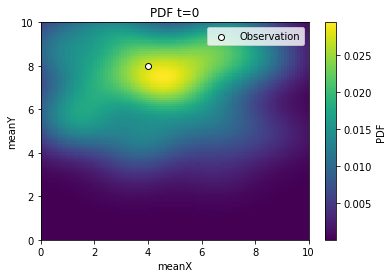

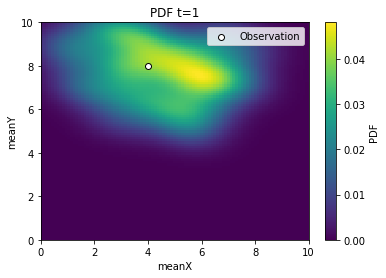

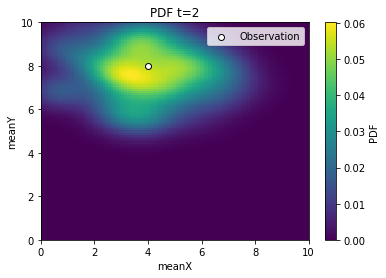

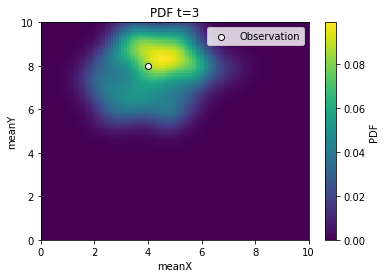

In [7]:
from pyabc.visualization import plot_kde_2d

for t in range(history.n_populations):
    df, w = abc.history.get_distribution(0, t)
    ax = plot_kde_2d(df, w, "meanX", "meanY",
                      xmin=0, xmax=10,
                      ymin=0, ymax=10,
                      numx=100, numy=100)
    ax.scatter([4], [8],
               edgecolor="black",
               facecolor="white",
               label="Observation");
    ax.legend();
    ax.set_title("PDF t={}".format(t))

In [8]:
history.get_sum_stats(1, 0)[1][0]["iris"].head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
